In [55]:
import warnings
warnings.filterwarnings("ignore")

## Dataset exploration

In [1]:
import pandas as pd

# Load the Parquet files (column names are read automatically)
train_df = pd.read_parquet("data/yelp-train.parquet")
test_df = pd.read_parquet("data/yelp-test.parquet")

train_df.columns = ['user_id', 'business_id', 'stars']
test_df.columns = ['user_id', 'business_id', 'stars']

# Concatenate train and test DataFrames
df = pd.concat([train_df, test_df], ignore_index=True)

# Display the first few rows of the DataFrame
print(df.head())

   user_id  business_id  stars
0   827556        88673      5
1   827556        36288      5
2   827556        30490      4
3  1202231        28754      4
4  1202231       122144      4


In [2]:
import pandas as pd

def calculate_dataset_stats(df):
    dataset_stats = {
        'Categories': ['#Interactions', '#Users', '#Items'],
        'Values': [len(df), df['user_id'].nunique(), df['business_id'].nunique()],
        'Colors': ['#7600FF', '#FF7800', '#009D00']
    }
    return pd.DataFrame(dataset_stats)

def calculate_data_quantity_heterogeneity(df):
    # Count the number of interactions (reviews/ratings) per business
    interactions_per_business = df.groupby('business_id').size()

    # Calculate the required statistics
    min_interactions = interactions_per_business.min()
    max_interactions = interactions_per_business.max()
    avg_interactions = interactions_per_business.mean()
    std_dev_interactions = interactions_per_business.std()
    variance_interactions = std_dev_interactions ** 2

    # Round the values
    min_interactions = round(min_interactions, 2)  # round to 2 decimal places
    max_interactions = round(max_interactions, 2)
    avg_interactions = round(avg_interactions, 2)
    std_dev_interactions = round(std_dev_interactions, 2)
    variance_interactions = round(variance_interactions, 2)

    data_quantity_heterogeneity = {
        'Metrics': ['#Min', '#Max', 'Average', 'St. Dev.', 'Variance'],
        'Values': [min_interactions, max_interactions, avg_interactions, std_dev_interactions, variance_interactions],
        'Colors': ['#00A3E8', '#B1001E', '#7600FF', '#FF7800', '#009D00']
    }
    
    return pd.DataFrame(data_quantity_heterogeneity)


In [3]:
# Let's try again with the correct import for make_subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Define the data for the plots
dataset_stats = calculate_dataset_stats(df)

data_quantity_heterogeneity = calculate_data_quantity_heterogeneity(df)

# Create the subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Evaluation Dataset Statistics", "Data Quantity Heterogeneity"))

# Add the dataset statistics bar chart
fig.add_trace(
    go.Bar(x=dataset_stats['Categories'], 
           y=dataset_stats['Values'], 
           marker_color=dataset_stats['Colors'],
           text=dataset_stats['Values'],
           textposition='auto'),
    row=1, col=1
)

# Add the data quantity heterogeneity bar chart
fig.add_trace(
    go.Bar(x=data_quantity_heterogeneity['Metrics'], 
           y=data_quantity_heterogeneity['Values'], 
           marker_color=data_quantity_heterogeneity['Colors'],
           text=data_quantity_heterogeneity['Values'],
           textposition='auto'),
    row=1, col=2
)

# Update y-axis to log scale for the first subplot
fig.update_yaxes(type="log", row=1, col=1)

# Update layout for better visibility
fig.update_layout(showlegend=False, height=600, width=1200)

# Show the plots
fig.show()

## Neuronal Colaborative Filtering implementation with Cornac 

Let's implement the cornac method to see comportement of GMF, MLP, NeuMF on yelp Dataset. We keep the parameters quoted in the report. 

In [78]:
import pandas as pd
# Load the Parquet files (column names are read automatically)
#train_df = pd.read_parquet("data/yelp-train.parquet").head(50000)
#test_df = pd.read_parquet("data/yelp-test.parquet").head(50000)


train_df = pd.read_csv("data/train_exp_200.csv")
test_df = pd.read_csv("data/test_exp_200.csv")


#train_df.columns = ['user_id', 'business_id', 'stars']
#test_df.columns = ['user_id', 'business_id', 'stars']

# Concatenate train and test DataFrames
df = pd.concat([train_df, test_df], ignore_index=True)

In [79]:
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader
from cornac.metrics import Precision, Recall, NDCG, MAP
import tempfile

with tempfile.NamedTemporaryFile(delete=False, suffix='.csv') as tmp_file:
    df.to_csv(tmp_file.name, index=False, header=False, sep='\t')

# Read the data using Cornac's Reader
reader = Reader()
feedback = reader.read(tmp_file.name, fmt='UIR')

# Define an evaluation method to split feedback into train and test sets
ratio_split = RatioSplit(
    data=feedback,
    test_size=0.2,
    rating_threshold=3.0,
    seed=123,
    exclude_unknowns=False,
    verbose=True,
)

backend = "tensorflow"  # or 'pytorch'

# Instantiate the recommender models to be compared
gmf = cornac.models.GMF(
    num_factors=8,
    num_epochs=10,
    learner="adam",
    backend=backend,
    batch_size=256,
    lr=0.001,
    num_neg=50,
    seed=123,
)
mlp = cornac.models.MLP(
    layers=[64, 32, 16, 8],
    act_fn="tanh",
    learner="adam",
    backend=backend,
    num_epochs=10,
    batch_size=256,
    lr=0.001,
    num_neg=50,
    seed=123,
)
neumf1 = cornac.models.NeuMF(
    num_factors=8,
    layers=[64, 32, 16, 8],
    act_fn="tanh",
    learner="adam",
    backend=backend,
    num_epochs=10,
    batch_size=256,
    lr=0.001,
    num_neg=50,
    seed=123,
)
neumf2 = cornac.models.NeuMF(
    name="NeuMF_pretrained",
    learner="sgd",
    backend=backend,
    num_epochs=10,
    batch_size=256,
    lr=0.001,
    num_neg=50,
    seed=123,
    num_factors=gmf.num_factors,
    layers=mlp.layers,
    act_fn=mlp.act_fn,
).from_pretrained(gmf, mlp, alpha=0.5)


# Specify the metrics to evaluate the model
metrics = [
    Precision(k=10),
    Recall(k=10),
    NDCG(k=10),
    MAP(),
    Precision(k=10),
    Recall(k=10),
]

# Put everything together into an experiment and run it
cornac.Experiment(
    eval_method=ratio_split,
    models=[
        gmf,
        mlp,
        neumf1,
        neumf2,
    ],
    metrics=metrics,
).run()

rating_threshold = 3.0
exclude_unknowns = False
---
Training data:
Number of users = 200
Number of items = 3390
Number of ratings = 3767
Max rating = 5.0
Min rating = 1.0
Global mean = 3.8
---
Test data:
Number of users = 200
Number of items = 4157
Number of ratings = 942
Number of unknown users = 0
Number of unknown items = 767
---
Total users = 200
Total items = 4157

[GMF] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]


[GMF] Evaluation started!


Ranking:   0%|          | 0/196 [00:00<?, ?it/s]


[MLP] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]


[MLP] Evaluation started!


Ranking:   0%|          | 0/196 [00:00<?, ?it/s]


[NeuMF] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]


[NeuMF] Evaluation started!


Ranking:   0%|          | 0/196 [00:00<?, ?it/s]


[NeuMF_pretrained] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]


[NeuMF_pretrained] Evaluation started!


Ranking:   0%|          | 0/196 [00:00<?, ?it/s]


TEST:
...
                 |    MAP | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
---------------- + ------ + ------- + ------------ + --------- + --------- + --------
GMF              | 0.0022 |  0.0023 |       0.0011 |    0.0041 |   13.4716 |   0.1602
MLP              | 0.0020 |  0.0021 |       0.0016 |    0.0042 |   10.3543 |   0.2681
NeuMF            | 0.0023 |  0.0019 |       0.0011 |    0.0041 |   10.5919 |   0.2954
NeuMF_pretrained | 0.0023 |  0.0021 |       0.0011 |    0.0041 |   10.6006 |   0.2683



## NeuMF from scratch 

In order to understand more the structure of NeuMF let's implement it from scratch with pytorch :

### Implicit vs. Explicit Datasets
In the context of recommender systems and user behavior analysis, datasets can be categorized into two types based on the nature of user feedback: implicit and explicit.

### Explicit Dataset

Explicit datasets contain direct feedback from users regarding their preferences. This feedback is usually in a structured form, such as ratings, reviews, or likes/dislikes. Key characteristics include:

- Ratings: Users provide a numerical rating (e.g., on a scale of 1 to 5) to an item.
- Reviews: Written feedback that often accompanies ratings.
- Likes/Dislikes: Binary feedback indicating preference or aversion.
Explicit feedback is clear and direct but requires active user participation to collect.

### Implicit Dataset

Implicit datasets are based on indirect feedback inferred from user actions. These actions are not direct indications of preference but can be interpreted as signals of interest or disinterest. Characteristics include:

- Page Views: The number of times a user views a page or item.
- Purchase History: Records of items a user has purchased.
- Time Spent: The duration a user spends on a particular item or page.
- Click-Throughs: Whether a user clicks on a recommendation or not.
Implicit feedback is more abundant and easier to collect but less definitive in expressing user preferences.

### The Role of Threshold in Implicit Datasets
In implicit datasets, feedback is inferred from user actions, which are ambiguous. A threshold is often set to distinguish between positive and negative feedback:

- Positive Interaction: If a user's interaction with an item exceeds a certain threshold, it can be interpreted as a positive signal.
- Negative Interaction: Interactions below the threshold might be considered negative or neutral.
- Quantifying Interest: The threshold helps in quantifying interest levels. Different thresholds can be experimented with to capture user behavior nuances.

### Importance of Thresholding
- Model Training: Distinguishing between positive and negative samples is crucial for machine learning models in recommender systems.
- Personalization: Accurate thresholding ensures better interpretations of user preferences, leading to improved personalization.
- Evaluation Metrics: It affects how evaluation metrics are calculated, defining what is considered 'relevant'.
- Bias and Noise Reduction: Proper thresholding can reduce noise and bias in the dataset.

In conclusion, the distinction between implicit and explicit datasets lies in how user preferences are expressed and collected. Thresholding in implicit datasets is vital for translating user behavior into actionable insights for personalized recommendations.

In [41]:
import pandas as pd

# Load the Parquet files (column names are read automatically)
train_df = pd.read_parquet("data/yelp-train.parquet")
test_df = pd.read_parquet("data/yelp-test.parquet")

train_df.columns = ['user_id', 'business_id', 'stars']
test_df.columns = ['user_id', 'business_id', 'stars']

# Concatenate train and test DataFrames
df = pd.concat([train_df, test_df], ignore_index=True)

# Display the firt few rows of the DataFrame
df.head()

,user_id,business_id,stars
0,827556,88673,5
1,827556,36288,5
2,827556,30490,4
3,1202231,28754,4
4,1202231,122144,4


In [42]:
def filter_num_user(df,n):
    user_interactions = df.groupby('user_id').size()
    users_with_min_interactions = user_interactions[user_interactions >= 10]
    selected_users = pd.Series(users_with_min_interactions.index).sample(n=200, random_state=1) 
    selected_df = df[df['user_id'].isin(selected_users)]
    return selected_df

In [43]:
df = filter_num_user(df,200)
threshold = 3
df['feedback'] = (df['stars'] >= threshold).astype(int)


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuMF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, layers):
        super(NeuMF, self).__init__()
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)

        # MLP layers
        mlp_layers = []
        input_size = 2 * num_factors
        for layer_size in layers:
            mlp_layers.append(nn.Linear(input_size, layer_size))
            mlp_layers.append(nn.Tanh())
            input_size = layer_size
        self.mlp = nn.Sequential(*mlp_layers)

        # Prediction layer
        self.prediction_layer = nn.Linear(input_size + num_factors, 1)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf

        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = torch.cat((p_mlp, q_mlp), dim=1)
        mlp = self.mlp(mlp)

        con_res = torch.cat((gmf, mlp), dim=1)
        output = self.prediction_layer(con_res)
        return output


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df['feedback'] = df['stars'].apply(lambda x: 1 if x >= 3 else 0)

# Encoding user_id and business_id
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()

df['user_id'] = user_encoder.fit_transform(df['user_id'])
df['business_id'] = business_encoder.fit_transform(df['business_id'])

# Splitting the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Number of unique users and businesses
num_users = df['user_id'].nunique()
num_items = df['business_id'].nunique()

In [46]:
positive_df = train_df[train_df['feedback'] == 1]
negative_df = train_df[train_df['feedback'] == 0]

# Sample negative instances
sampled_negative_df = negative_df.sample(n=len(positive_df) * 50, replace=True, random_state=42)

# Combine positive and sampled negative instances
combined_df = pd.concat([positive_df, sampled_negative_df]).reset_index(drop=True)

In [47]:
len(train_df["user_id"].unique())

200

In [50]:
positive_df = test_df[test_df['feedback'] == 1]
negative_df = test_df[test_df['feedback'] == 0]

# Sample negative instances
sampled_negative_df_test = negative_df.sample(n=len(positive_df) * 50, replace=True, random_state=42)

# Combine positive and sampled negative instances
combined_df_test = pd.concat([positive_df, sampled_negative_df]).reset_index(drop=True)

In [51]:
len(combined_df_test["user_id"].unique())

199

In [52]:
import torch
from torch.utils.data import Dataset, DataLoader

class ImplicitDataset(Dataset):
    def __init__(self, users, items, feedback):
        self.users = torch.tensor(users, dtype=torch.long)
        self.items = torch.tensor(items, dtype=torch.long)
        self.feedback = torch.tensor(feedback, dtype=torch.float)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.feedback[idx]

# Create datasets
combined_dataset_train = ImplicitDataset(combined_df['user_id'].values, combined_df['business_id'].values, combined_df['feedback'].values)
combined_dataset_test = ImplicitDataset(combined_df_test['user_id'].values, combined_df_test['business_id'].values, combined_df_test['feedback'].values)

In [66]:
from tqdm import tqdm
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Set seed for reproducibility
torch.manual_seed(123)

# Instantiate the model
model = NeuMF(8, num_users, num_items, layers=[64, 32, 16, 8]).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Criterion
criterion = torch.nn.BCEWithLogitsLoss()
epochs = 10
# Training loop
for epoch in range(epochs):
    start_time = time.time() 
    model.train()
    total_loss = 0
    train_loader = DataLoader(combined_dataset_train, batch_size=256, shuffle=True)

    # Using tqdm for progress tracking
    loop = tqdm(train_loader, leave=True)
    for user_ids, item_ids, feedback in loop:
        user_ids, item_ids, feedback = user_ids.to(device), item_ids.to(device), feedback.to(device)
        optimizer.zero_grad()
        predictions = model(user_ids, item_ids).squeeze()
        loss = criterion(predictions, feedback)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Update tqdm loop display
        loop.set_description(f'Epoch [{epoch + 1}/{epochs}]')
        loop.set_postfix(loss=loss.item())
        epoch_duration = time.time() - start_time  
    print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(train_loader)}, Time per epoch: {epoch_duration:.2f} seconds")

Epoch [1/10]: 100%|██████████| 610/610 [00:01<00:00, 337.70it/s, loss=0.031] 


Epoch 1, Average Loss: 0.17895645576483402, Time per epoch: 1.81 seconds


Epoch [2/10]: 100%|██████████| 610/610 [00:01<00:00, 341.73it/s, loss=0.0807]


Epoch 2, Average Loss: 0.08155318052187317, Time per epoch: 1.79 seconds


Epoch [3/10]: 100%|██████████| 610/610 [00:01<00:00, 342.20it/s, loss=0.00899]


Epoch 3, Average Loss: 0.05701489753746351, Time per epoch: 1.78 seconds


Epoch [4/10]: 100%|██████████| 610/610 [00:01<00:00, 325.34it/s, loss=0.079]  


Epoch 4, Average Loss: 0.034906752351060756, Time per epoch: 1.88 seconds


Epoch [5/10]: 100%|██████████| 610/610 [00:01<00:00, 332.20it/s, loss=0.0351] 


Epoch 5, Average Loss: 0.019314375898388567, Time per epoch: 1.84 seconds


Epoch [6/10]: 100%|██████████| 610/610 [00:01<00:00, 323.44it/s, loss=0.00214]


Epoch 6, Average Loss: 0.009344257887063518, Time per epoch: 1.89 seconds


Epoch [7/10]: 100%|██████████| 610/610 [00:01<00:00, 330.39it/s, loss=0.00062] 


Epoch 7, Average Loss: 0.004894849737212978, Time per epoch: 1.85 seconds


Epoch [8/10]: 100%|██████████| 610/610 [00:01<00:00, 332.89it/s, loss=0.000684]


Epoch 8, Average Loss: 0.0028209465017664383, Time per epoch: 1.83 seconds


Epoch [9/10]: 100%|██████████| 610/610 [00:01<00:00, 322.20it/s, loss=0.000824]


Epoch 9, Average Loss: 0.0016960133481618079, Time per epoch: 1.89 seconds


Epoch [10/10]: 100%|██████████| 610/610 [00:01<00:00, 359.34it/s, loss=0.000169]

Epoch 10, Average Loss: 0.0010637005188475653, Time per epoch: 1.70 seconds


## Metrics Calculation for Recommender Systems



### Function Definitions
#### dcg_at_k(scores, k)
Calculates the Discounted Cumulative Gain (DCG) at rank `k`. DCG is a measure of ranking quality that considers the position of correct recommendations, giving higher importance to items at the top of the recommendation list.

**Formula**: 
$$ \text{DCG@k} = \sum_{i=1}^{k} \frac{2^{scores_i} - 1}{\log_2(i+1)} $$

#### ndcg_at_k(true_scores, pred_scores, k)
Calculates the Normalized Discounted Cumulative Gain (NDCG) at rank `k`. NDCG is the normalized version of DCG, where the DCG value is divided by the Ideal DCG (IDCG), ensuring a range from 0 to 1.

**Formula**: 
$$ \text{NDCG@k} = \frac{\text{DCG@k (pred\_scores)}}{\text{DCG@k (true\_scores)}} $$

#### compute_metrics(model, data_loader, k=10)
Evaluates the model's performance using the provided `data_loader`. The metrics calculated are Mean Average Precision (MAP), NDCG@10, Precision@10, and Recall@10.

- **MAP**: A metric for evaluating ranked retrieval results. The average precision is computed for each query and then averaged over all queries.
- **NDCG@10**: Measures the quality of the recommended items in the top-10 of the ranked list.
- **Precision@10**: The fraction of relevant items among the top-10 recommended items.
- **Recall@10**: The fraction of the total amount of relevant items that are recommended in the top-10.

**Formulas**:
- MAP: 
$$ \text{MAP} = \frac{1}{Q} \sum_{q=1}^{Q} \text{Average Precision (q)} $$
- Precision@k: 
$$ \text{Precision@k} = \frac{\text{Number of relevant items in top-k}}{k} $$
- Recall@k: 
$$ \text{Recall@k} = \frac{\text{Number of relevant items in top-k}}{\text{Total number of relevant items}} $$




In [68]:
import numpy as np
from sklearn.metrics import average_precision_score
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def dcg_at_k(scores, k):
    """Compute DCG at rank k."""
    scores = scores[:k]  # Consider only top-k scores
    return np.sum((np.power(2, scores) - 1) / np.log2(np.arange(2, k + 2)), dtype=np.float32)

def ndcg_at_k(true_scores, pred_scores, k):
    """Compute NDCG at rank k."""
    if len(pred_scores) < k:
        k = len(pred_scores)  

    # Get the indices of the scores, sorted by predicted score in descending order
    order = np.argsort(pred_scores)[::-1]
    true_scores_sorted = true_scores[order]

    # Compute DCG for the top k predicted scores
    dcg_k = dcg_at_k(true_scores_sorted, k)

    # Compute IDCG for the top k true scores
    ideal_order = np.argsort(true_scores)[::-1]
    ideal_scores_sorted = true_scores[ideal_order]
    idcg_k = dcg_at_k(ideal_scores_sorted, k)

    if idcg_k == 0:
        return 0.0  # Return 0 if there are no relevant items

    return dcg_k / idcg_k


def compute_metrics(model, data_loader, k=10):
    model.eval()
    AP_scores = []
    NDCG_scores = []
    precision_scores = []
    recall_scores = []

    with torch.no_grad():
        loop = tqdm(data_loader, leave=True)
        for user_ids, item_ids, actuals in loop:
            user_ids, item_ids, actuals = user_ids.to(device), item_ids.to(device), actuals.to(device)
            predictions = model(user_ids, item_ids).squeeze()
            
            # Converting predictions to CPU for metric calculation
            predictions = predictions.cpu().numpy()
            actuals = actuals.cpu().numpy()
            
            # Rank items and select top-k
            topk_indices = np.argsort(predictions)[::-1][:k]
            topk_preds = predictions[topk_indices]
            topk_actuals = actuals[topk_indices]

            # Calculate metrics
            AP_scores.append(average_precision_score(actuals, predictions))
            NDCG_scores.append(ndcg_at_k(actuals, predictions, k=k)) 
            precision_scores.append(np.mean(topk_actuals))
            if np.sum(actuals) == 0:
                recall = 0.0  
            else:
                recall = np.sum(topk_actuals) / np.sum(actuals)

            recall_scores.append(recall)

    return {
        "MAP": np.mean(AP_scores),
        "NDCG@10": np.mean(NDCG_scores),
        "Precision@10": np.mean(precision_scores),
        "Recall@10": np.mean(recall_scores)
    }


# Example usage after training
test_loader = DataLoader(combined_dataset_test, batch_size=256, shuffle=True) 
metrics = compute_metrics(model, test_loader)
print(metrics)

100%|██████████| 601/601 [00:00<00:00, 789.51it/s]

{'MAP': 0.713465521013229, 'NDCG@10': 0.7140558923342065, 'Precision@10': 0.12995009, 'Recall@10': 0.7139489739984521}


In [57]:
df.rename(columns={'business_id': 'item_id'}, inplace=True)
df.rename(columns={'stars': 'rating'}, inplace=True)
df = df.drop(columns="feedback")
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
df
train_df.to_csv("data/train_exp_200.csv",index=False)
test_df.to_csv("data/test_exp_200.csv",index=False)

## FedNeuMF

Now let's implement the FedNeuMF local experiment by taking inspiration from https://github.com/AmanPriyanshu/Federated-Recommendation-Neural-Collaborative-Filtering/tree/main and https://github.com/Ach113/federeco/tree/main 

### Dataset

In [70]:
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MODEL_PARAMETERS = {
    'default_model': {
        'mf_dim': 8,
        'layers': [64, 32, 16, 8],
        'reg_layers': [0, 0, 0, 0],
        'reg_mf': 0
    },
    'FedNCF': {
        'mf_dim': 16,
        'layers': [64, 32, 16, 8],
        'reg_layers': [0, 0, 0, 0],
        'reg_mf': 0
    },
}

BATCH_SIZE = 64
NUM_NEGATIVES = 50
THRESHOLD = 3

In [71]:
from typing import List, Tuple
import pandas as pd
import scipy as sp
import numpy as np
import sys
import os


def load_csv_parts(dataset):
    # Load each part
    columns = ['user_id', 'item_id', 'rating']
    df_part1 = pd.read_csv(os.path.join('data', dataset + '-train_1.csv'), header=None, names=columns)
    df_part2 = pd.read_csv(os.path.join('data', dataset + '-train_2.csv'), header=None, names=columns)

    return pd.concat([df_part1, df_part2], ignore_index=True)


class Dataset:

    def __init__(self, dataset: str):
        columns = ['user_id', 'item_id', 'rating']
        self.train_df = train_df
        self.test_df = test_df
        #self.train_df = load_csv_parts(dataset).head(80000)
        #self.test_df = pd.read_csv(os.path.join('data', dataset + '-test.csv'), names=columns).head(20000)
        self.neg_path = os.path.join('data', dataset + '-neg.csv')
        self.num_users, self.num_items = self.get_matrix_dim()
        print(f'Loaded `{dataset}` dataset: \nNumber of users - {self.num_users}, Number of items - {self.num_items}')

    def get_matrix_dim(self) -> Tuple[int, int]:
        
        num_users = max(self.train_df['user_id']) + 1
        num_items = max(self.train_df['item_id']) + 1
        return num_users, num_items

    def load_client_train_data(self) -> List[List]:
        
        mat = sp.sparse.dok_matrix((self.num_users+1, self.num_items+1), dtype=np.float32)

        for user, item, rating in self.train_df.values:
            if rating >= THRESHOLD:
                mat[user, item] = 1.0

        client_datas = [[[], [], []] for _ in range(self.num_users)]

        for (usr, item) in mat.keys():
            client_datas[usr][0].append(usr)
            client_datas[usr][1].append(item)
            client_datas[usr][2].append(1)
            for t in range(NUM_NEGATIVES):
                neg = np.random.randint(self.num_items)
                while (usr, neg) in mat.keys():
                    neg = np.random.randint(self.num_items)
                client_datas[usr][0].append(usr)
                client_datas[usr][1].append(neg)
                client_datas[usr][2].append(0)

        return client_datas

    def load_test_file(self) -> List[List[int]]:
       
        return [[user, item] for user, item, _ in self.test_df.values]

    def load_negative_file(self) -> List[List[int]]:
        
        negative_list = []
        with open(self.neg_path, "r") as f:
            line = f.readline()
            while line is not None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1:]:
                    negatives.append(int(x))
                negative_list.append(negatives)
                line = f.readline()
        return negative_list


### Client

In [72]:
from typing import List, Optional, Any, Tuple
from torch import Tensor
import pandas as pd
import numpy as np
import torch
from typing import Tuple, Any, Optional, List
from abc import ABC, abstractmethod


class Client2(ABC):

    @abstractmethod
    def __init__(self, client_id: int):
        self.client_id = client_id

    @abstractmethod
    def train(self,
              server_model: torch.nn.Module,
              local_epochs: int,
              learning_rate: float) -> Tuple[dict[str, Any], Tensor]:
        
        pass

    @abstractmethod
    def generate_recommendation(self, server_model: torch.nn.Module,
                                num_items: int,  k: Optional[int] = 5) -> List[int]:
        
        pass


class Client(Client2):

    def __init__(self, client_id: int):
        super().__init__(client_id)
        self.client_id = client_id
        self.client_data = None

    def set_client_data(self, data_array: List[np.ndarray]):
        self.client_data = pd.DataFrame({
            'user_id': data_array[0],
            'item_id': data_array[1],
            'label': data_array[2]
        })

    def train(self, server_model: torch.nn.Module, local_epochs: int, learning_rate: float) -> Tuple[dict[str, Any], Tensor]:
     
        user_input, item_input = self.client_data['user_id'], self.client_data['item_id']
        labels = self.client_data['label']

        user_input = torch.tensor(user_input, dtype=torch.int, device=DEVICE)
        item_input = torch.tensor(item_input, dtype=torch.int, device=DEVICE)
        labels = torch.tensor(labels, dtype=torch.int, device=DEVICE)

        # utilize dataloader to train in batches
        dataset = torch.utils.data.TensorDataset(user_input, item_input, labels)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        # perturb the learning rate
        # learning_rate = abs(learning_rate + np.random.normal(0, .01, 1).squeeze())
        optimizer = torch.optim.AdamW(server_model.parameters(), lr=learning_rate)
        loss = None
        for _ in range(local_epochs):
            for _, (u, i, l) in enumerate(dataloader):
                logits, loss = server_model(u, i, l)
                optimizer.zero_grad(set_to_none=True)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(server_model.parameters(), 0.5)
                optimizer.step()

        return server_model.state_dict(), loss

    def generate_recommendation(self, server_model: torch.nn.Module,
                                num_items: int,  k: Optional[int] = 5) -> List[int]:
        """
        :param server_model: server model which will be used to generate predictions
        :param num_items: total number of unique items in dataset
        :param k: number of recommendations to generate
        :return: list of `k` movie recommendations
        """
        # get movies that user has not yet interacted with
        buisness = set(range(num_items)).difference(set(self.client_data['item_id'].tolist()))
        buisness = torch.tensor(list(buisness), dtype=torch.int, device=DEVICE)
        client_id = torch.tensor([self.client_id for _ in range(len(buisness))], dtype=torch.int, device=DEVICE)
        # obtain predictions in terms of logit per movie
        with torch.no_grad():
            logits, _ = server_model(client_id, buisness)

        rec_dict = {movie: p for movie, p in zip(buisness.tolist(), logits.squeeze().tolist())}
        # select top k recommendations
        top_k = sorted(rec_dict.items(), key=lambda x: -x[1])[:k]
        rec, _ = zip(*top_k)

        return rec
    

    
def initialize_clients(dataset: Dataset) -> List[Client2]:
    
    clients = list()
    client_dataset = dataset.load_client_train_data()

    for client_id in range(dataset.num_users):
        if not client_dataset[client_id][0]:
            continue
        c = Client(client_id)
        c.set_client_data(client_dataset[client_id])
        clients.append(c)
    return clients



### Serveur

In [73]:
from typing import List, Any, Tuple, Optional
import matplotlib.pyplot as plt
import pickle
import collections
import random
import torch
import copy
import tqdm


def plot_loss(epochs: int, loss: List[float], num_clients: int):
    
    plt.plot(list(range(epochs)), loss)
    plt.xlabel('Epochs')
    plt.ylabel('BCE Loss')
    plt.title(f'Mean loss across {num_clients} clients per epoch')
    plt.show()


def sample_clients(clients: List[Client2], num_clients: int) -> Tuple[List[Client2], List[Client2]]:
    
    sample = clients[:num_clients]
    # rotate the list by `num_clients`
    clients = clients[num_clients:] + sample

    return sample, clients


def training_process(server_model: torch.nn.Module,
                     all_clients: List[Client2],
                     num_clients: int,
                     epochs: int,
                     local_epochs: int,
                     learning_rate: float,
                     plot: Optional[bool] = True) -> dict[str, Any]:
    
    random.shuffle(all_clients)
    total_loss = list()
    pbar = tqdm.tqdm(range(epochs))
    for epoch in pbar:
        # sample `num_clients` clients for training
        clients, all_clients = sample_clients(all_clients, num_clients)
        # apply single round of training
        w, loss = single_train_round(server_model, clients, local_epochs, learning_rate)
        total_loss.append(loss)
        # aggregate weights

        updated_server_weights = federated_averaging(w)
        # set aggregated weights to server model
        server_model.load_state_dict(updated_server_weights)
        # display progress bar with epochs & mean loss of single training round
        pbar.set_description(f'epoch: {epoch+1}, loss: {loss:.2f}')

    if plot:
        plot_loss(epochs, total_loss, num_clients)

    return server_model.state_dict()


def single_train_round(server_model: torch.nn.Module,
                       clients: List[Client],
                       local_epochs: int,
                       learning_rate: float) -> Tuple[List[collections.OrderedDict], float]:
    
    client_weights = list()
    mean_loss = 0
    for client in clients:
        server_model_copy = copy.deepcopy(server_model)
        weights, loss = client.train(server_model_copy, local_epochs, learning_rate)
        mean_loss += float(loss.cpu().detach().numpy())
        client_weights.append(weights)
    return client_weights, mean_loss / len(client_weights)


def federated_averaging(client_weights: List[collections.OrderedDict]) -> collections.OrderedDict:
    
    keys = client_weights[0].keys()
    averages = copy.deepcopy(client_weights[0])

    for w in client_weights[1:]:
        for key in keys:
            averages[key] += w[key]

    for key in keys:
        averages[key] /= len(client_weights)
    return averages


## Model

In [74]:
from torch.nn import functional as F
from typing import Optional, Tuple
from torch import Tensor
import torch


class NeuralCollaborativeFiltering(torch.nn.Module):

    def __init__(self, num_users: int, num_items: int):
        super().__init__()
        params = MODEL_PARAMETERS['FedNCF']
        layers = params['layers']
        mf_dim = params['mf_dim']
        mlp_dim = int(layers[0] / 2)

        self.mf_embedding_user = torch.nn.Embedding(num_embeddings=num_users, embedding_dim=mf_dim, device=DEVICE)
        self.mf_embedding_item = torch.nn.Embedding(num_embeddings=num_items, embedding_dim=mf_dim, device=DEVICE)

        self.mlp_embedding_user = torch.nn.Embedding(num_embeddings=num_users, embedding_dim=mlp_dim, device=DEVICE)
        self.mlp_embedding_item = torch.nn.Embedding(num_embeddings=num_items, embedding_dim=mlp_dim, device=DEVICE)

        self.mlp = torch.nn.ModuleList()
        current_dim = 64
        for idx in range(1, len(layers)):
            self.mlp.append(torch.nn.Linear(current_dim, layers[idx]))
            current_dim = layers[idx]
            self.mlp.append(torch.nn.ReLU())
        self.output_layer = torch.nn.Linear(in_features=24, out_features=1, device=DEVICE)

    def forward(self, user_input: Tensor,
                item_input: Tensor,
                target: Optional[Tensor] = None) -> Tuple[Tensor, Optional[float]]:
        # matrix factorization
        mf_user_latent = torch.nn.Flatten()(self.mf_embedding_user(user_input))
        mf_item_latent = torch.nn.Flatten()(self.mf_embedding_item(item_input))
        mf_vector = torch.mul(mf_user_latent, mf_item_latent)
        # mlp
        mlp_user_latent = torch.nn.Flatten()(self.mlp_embedding_user(user_input))
        mlp_item_latent = torch.nn.Flatten()(self.mlp_embedding_item(item_input))
        mlp_vector = torch.cat([mlp_user_latent, mlp_item_latent], dim=1)

        for layer in self.mlp:
            mlp_vector = layer(mlp_vector)

        predict_vector = torch.cat([mf_vector, mlp_vector], dim=1)
        logits = self.output_layer(predict_vector)

        loss = None
        if target is not None:
            target = target.view(target.shape[0], 1).to(torch.float32)
            loss = F.binary_cross_entropy_with_logits(logits, target)

        logits = torch.nn.Sigmoid()(logits)

        return logits, loss


## Metrics

In [75]:
from typing import List
import torch.nn
import os
from collections import defaultdict
from typing import Tuple, List
import numpy as np
import heapq
import torch
import math
from sklearn.metrics import average_precision_score

def dcg_at_k(scores, k):
    """Compute DCG at rank k."""
    scores = scores[:k]  # Consider only top-k scores
    return np.sum((np.power(2, scores) - 1) / np.log2(np.arange(2, k + 2)), dtype=np.float32)

def ndcg_at_k(true_scores, pred_scores, k):
    """Compute NDCG at rank k."""
    order = np.argsort(pred_scores)[::-1]
    
    # Ensure true_scores and pred_scores are numpy arrays
    true_scores = np.array(true_scores)
    pred_scores = np.array(pred_scores)

    true_scores_sorted = true_scores[order[:k]]

    # Compute DCG for the sorted true scores
    idcg = dcg_at_k(true_scores_sorted, k)
    if not idcg:
        return 0.0

    # Compute DCG for the predicted scores
    dcg = dcg_at_k(pred_scores[order[:k]], k)
    return dcg / idcg



def compute_metrics(model: torch.nn.Module, dataset: Dataset, k: int):
    model.eval()
    AP_scores = []
    NDCG_scores = []
    precision_scores = []
    recall_scores = []

    # Load test data and negative samples
    test_data = dataset.load_test_file()
    negative_samples = dataset.load_negative_file()

    with torch.no_grad():
        for test_instance, negatives in zip(test_data, negative_samples):
            try:
                user_id = test_instance[0]
                item_id = test_instance[1]
                
                # Combine positive and negative items for this user
                all_items = [item_id] + negatives

                # Create tensors for all items and the user
                item_input_dev = torch.tensor(all_items, dtype=torch.int, device=DEVICE)
                user_input = torch.tensor(np.full(len(item_input_dev), user_id, dtype='int32'), dtype=torch.int, device=DEVICE)

                pred, _ = model(user_input, item_input_dev)
                predictions = pred.squeeze()

                # Check if predictions is a 1-dimensional array
                if predictions.ndim == 0:
                    predictions = np.array([predictions.cpu().numpy()])
                else:
                    predictions = predictions.cpu().numpy()

                # Actual labels: 1 for the test item, 0 for negatives
                actuals = [1] + [0] * len(negatives)
                
                # Rank items and select top-k
                topk_indices = np.argsort(predictions)[::-1][:k]
                topk_preds = predictions[topk_indices]
                topk_actuals = [actuals[i] for i in topk_indices]
                
                # Calculate metrics
                AP_scores.append(average_precision_score(topk_actuals, topk_preds))
                NDCG_scores.append(ndcg_at_k(topk_actuals, topk_preds, k=k))
                precision_scores.append(np.mean(topk_actuals))
                recall = np.sum(topk_actuals) / np.sum(actuals) if np.sum(actuals) > 0 else 0.0
                recall_scores.append(recall)
            
        
            except IndexError as e:
                print("User not in train")
                # Handle the error or pass
                pass

    return {
        "MAP": np.mean(AP_scores),
        "NDCG@10": np.mean(NDCG_scores),
        "Precision@10": np.mean(precision_scores),
        "Recall@10": np.mean(recall_scores)
    }


def run_server(dataset: Dataset,
               num_clients: int,
               epochs: int,
               local_epochs: int,
               learning_rate: float) -> torch.nn.Module:
    
    # define server side model
    server_model = NeuralCollaborativeFiltering(dataset.num_users, dataset.num_items)
    server_model.to(DEVICE)

    clients = initialize_clients(dataset)
    
    trained_weights = training_process(server_model, clients, num_clients, epochs, local_epochs, learning_rate)

    server_model.load_state_dict(trained_weights)

    

    # Call the updated compute_metrics function
    metrics = compute_metrics(server_model, dataset, 10)
    return server_model


### Main

Loaded `yelp` dataset: 
Number of users - 200, Number of items - 4157


epoch: 10, loss: 0.11: 100%|██████████| 10/10 [01:37<00:00,  9.76s/it]


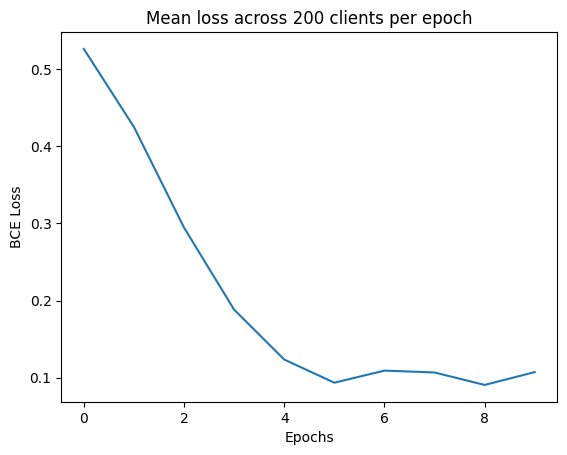

{'MAP': 1.0, 'NDCG@10': 0.018316075, 'Precision@10': 1.0, 'Recall@10': 1.0}


In [80]:
def main():

    # instantiate the dataset based on passed argument
    dataset = Dataset("yelp")
    # run the server to load the existing model or train & save a new one
    model = run_server(
        dataset=dataset,
        num_clients=200,
        epochs=10,
        local_epochs=3,
        learning_rate=0.001
    )
    
main()

## fask API Experiment

Now let's adapt the fonctions to transforme fedNeuMF to its API equivalent

In [63]:
import requests
import pickle

def get_updated_weights_from_server(url, model):
    """
    Fetches updated model weights from the server and loads them into the provided model.

    :param url: URL of the server endpoint to get updated weights.
    :param model: The PyTorch model to update.
    """
    try:
        response = requests.get(url)
        if response.status_code == 200:
            # Assuming the server sends a file, we save it temporarily
            with open("temp_model_weights.pth", "wb") as file:
                file.write(response.content)

            # Load the downloaded weights into the model
            model.load_state_dict(torch.load("temp_model_weights.pth"))
            print("Model weights updated successfully.")

            # Optionally, delete the temporary file after updating the model
            import os
            os.remove("temp_model_weights.pth")
        else:
            print(f"Failed to download weights. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {e}")



In [64]:
def send_weights_to_server(url, model_weights):
    """
    Send model weights to the server.

    :param url: URL of the server endpoint expecting the model weights.
    :param model_weights: Weights of the model to be sent.
    """
    # Serialize the model weights. You might use pickle or another method depending on your requirements.
    serialized_weights = pickle.dumps(model_weights)

    # Send the POST request with the serialized weights
    response = requests.post(url, files={'file': ('weights.pkl', serialized_weights, 'application/octet-stream')})

    # Check if the request was successful
    if response.status_code == 200:
        print("Weights successfully sent to the server.")
        return None
    else:
        print(f"Failed to send weights. Status code: {response.status_code}")
        return None


In [73]:
from typing import List, Any, Tuple, Optional
import matplotlib.pyplot as plt
import pickle
import collections
import random
import torch
import copy
import tqdm

def training_process(server_model: torch.nn.Module,
                     all_clients: List[Client2],
                     num_clients: int,
                     epochs: int,
                     local_epochs: int,
                     learning_rate: float,
                     plot: Optional[bool] = True) -> dict[str, Any]:
    

    random.shuffle(all_clients)
    total_loss = list()
    pbar = tqdm.tqdm(range(epochs))
    for epoch in pbar:
        # sample `num_clients` clients for training
        clients, all_clients = sample_clients(all_clients, num_clients)
        # apply single round of training
        loss = single_train_round(server_model, clients, local_epochs, learning_rate)
        total_loss.append(loss)
        get_updated_weights_from_server("http://127.0.0.1:8080/get_weights",server_model)
        
        # display progress bar with epochs & mean loss of single training round
        pbar.set_description(f'epoch: {epoch+1}, loss: {loss:.2f}')

    if plot:
        plot_loss(epochs, total_loss, num_clients)

    with open('loss.pkl', 'wb') as f:
        pickle.dump(total_loss, f)

    return server_model.state_dict()


def single_train_round(server_model: torch.nn.Module,
                       clients: List[Client],
                       local_epochs: int,
                       learning_rate: float) -> Tuple[List[collections.OrderedDict], float]:
    
    mean_loss = 0
    for client in clients:
        server_model_copy = copy.deepcopy(server_model)
        # Calculate the size of the model weights before training
        #model_size_before = sum(param.numel() * param.element_size() for param in server_model_copy.parameters())
        #model_size_before_mb = model_size_before / (1024 ** 2)

        weights, loss = client.train(server_model_copy, local_epochs, learning_rate)

        # Calculate the size of the model weights after training
        #model_size_after = sum(param.numel() * param.element_size() for param in server_model_copy.parameters())
        #model_size_after_mb = model_size_after / (1024 ** 2)

        #print(f"Size of model weights before training: {model_size_before_mb:.2f} MB")
        #print(f"Size of model weights after training: {model_size_after_mb:.2f} MB")
        # Calculate the size of the model in bytes
        #model_size_bytes = sum(param.numel() * param.element_size() for param in server_model.parameters())

        # Convert the size to megabytes
        #model_size_mb = model_size_bytes / (1024 ** 2)

        #print(f"Model size: {model_size_mb:.2f} MB")

        weights, loss = client.train(server_model_copy, local_epochs, learning_rate)
        mean_loss += float(loss.cpu().detach().numpy())
        send_weights_to_server("http://127.0.0.1:8080/train",weights)
    return  mean_loss / len(clients)



def federated_averaging(client_weights: List[collections.OrderedDict]) -> collections.OrderedDict:
    """
    calculates the average of client weights
    """
    keys = client_weights[0].keys()
    averages = copy.deepcopy(client_weights[0])

    for w in client_weights[1:]:
        for key in keys:
            averages[key] += w[key]

    for key in keys:
        averages[key] /= len(client_weights)
    return averages


See Final_project_server.ipynb to lunch the simulation

Loaded `yelp` dataset: 
Number of users - 200, Number of items - 3082


  0%|          | 0/10 [00:00<?, ?it/s]

Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weig

epoch: 1, loss: 0.56:  10%|█         | 1/10 [00:03<00:33,  3.70s/it]

Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model si

epoch: 2, loss: 0.38:  20%|██        | 2/10 [00:07<00:28,  3.58s/it]

Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model si

epoch: 3, loss: 0.42:  30%|███       | 3/10 [00:10<00:23,  3.38s/it]

Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model si

epoch: 4, loss: 0.34:  40%|████      | 4/10 [00:15<00:24,  4.01s/it]

Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model si

epoch: 5, loss: 0.35:  50%|█████     | 5/10 [00:18<00:19,  3.85s/it]

Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model si

epoch: 6, loss: 0.33:  60%|██████    | 6/10 [00:22<00:14,  3.71s/it]

Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to 

epoch: 7, loss: 0.34:  70%|███████   | 7/10 [00:25<00:10,  3.51s/it]

Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model si

epoch: 8, loss: 0.30:  80%|████████  | 8/10 [00:30<00:07,  3.92s/it]

Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model si

epoch: 9, loss: 0.18:  90%|█████████ | 9/10 [00:33<00:03,  3.77s/it]

Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model weights updated successfully.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model size: 0.61 MB
Weights successfully sent to the server.
Model si

epoch: 10, loss: 0.18: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it]

Weights successfully sent to the server.
Model weights updated successfully.


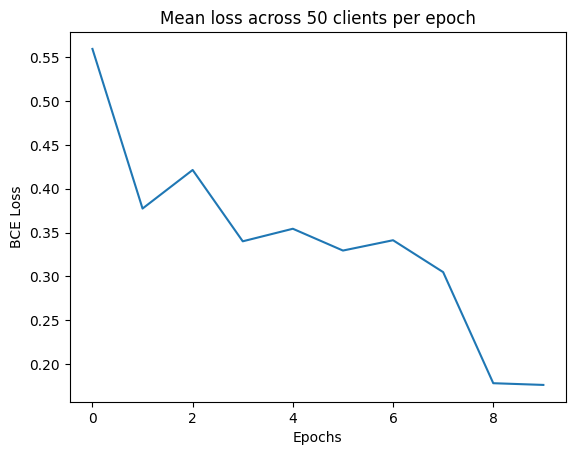

{'MAP': 1.0, 'NDCG@10': 0.2879949, 'Precision@10': 1.0, 'Recall@10': 1.0}


In [75]:
def API_SIMULATION():

    # instantiate the dataset based on passed argument
    dataset = Dataset("yelp")
  
    # run the server to load the existing model or train & save a new one
    run_server(
        dataset=dataset,
        num_clients=50,
        epochs=10,
        local_epochs=3,
        learning_rate=0.001
    )

API_SIMULATION()